In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import time
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.optimizers import SGD, Adam

# Enable eager execution
tf.config.run_functions_eagerly(True)

# MNIST Neural Network Experiments

This notebook implements various neural network architectures on the MNIST dataset with different optimizers, activation functions, and hyperparameters.

In [8]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# Reduce training size by 1/10 as requested
print("Reducing training size by 1/10...")
n_samples = len(x_train_full) // 10
indices = np.random.choice(len(x_train_full), n_samples, replace=False)
x_train_reduced = x_train_full[indices]
y_train_reduced = y_train_full[indices]

print(f"Original training size: {len(x_train_full)}")
print(f"Reduced training size: {len(x_train_reduced)}")
print(f"Test size: {len(x_test)}")
print(f"Image shape: {x_train_reduced[0].shape}")

# Normalize pixel values to [0, 1]
x_train_reduced = x_train_reduced.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Loading MNIST dataset...
Reducing training size by 1/10...
Original training size: 60000
Reduced training size: 6000
Test size: 10000
Image shape: (28, 28)


In [9]:
# Define Radial Basis Function (RBF) as specified
def RBF(x, c, s):
    """
    Radial Basis Function
    x: actual value
    c: center (assumed as mean)
    s: standard deviation
    """
    return np.exp(-np.sum((x - c) ** 2, axis=1) / (2 * s ** 2))

def convert_28x28_to_32x32_rbf(images):
    """
    Convert 28x28 images to 32x32 using RBF transformation (optimized version)
    """
    n_samples = images.shape[0]
    new_images = np.zeros((n_samples, 32, 32))
    
    print("Converting 28x28 images to 32x32 using RBF transformation (optimized)...")
    
    # Calculate center and standard deviation for RBF
    center = np.mean(images, axis=(1, 2))  # Mean of each image
    std = np.std(images, axis=(1, 2))      # Std of each image
    
    # Vectorized approach for faster processing
    for i in range(n_samples):
        if i % 1000 == 0:
            print(f"Processing image {i}/{n_samples}")
        
        # Simple upsampling from 28x28 to 32x32
        # Pad with 2 pixels on each side
        padded = np.pad(images[i], ((2, 2), (2, 2)), mode='constant', constant_values=0)
        
        # Apply RBF transformation if std > 0
        if std[i] > 0:
            # Apply RBF to each pixel
            rbf_factor = np.exp(-((padded - center[i]) ** 2) / (2 * std[i] ** 2))
            new_images[i] = padded * rbf_factor
        else:
            new_images[i] = padded
    
    return new_images

# Apply RBF transformation to convert 28x28 to 32x32
print("\\nApplying RBF transformation...")
x_train_32x32 = convert_28x28_to_32x32_rbf(x_train_reduced)
x_test_32x32 = convert_28x28_to_32x32_rbf(x_test)

print(f"New image shape: {x_train_32x32[0].shape}")
print(f"Training data shape: {x_train_32x32.shape}")
print(f"Test data shape: {x_test_32x32.shape}")

\nApplying RBF transformation...
Converting 28x28 images to 32x32 using RBF transformation (optimized)...
Processing image 0/6000
Processing image 1000/6000
Processing image 2000/6000
Processing image 3000/6000
Processing image 4000/6000
Processing image 5000/6000
Converting 28x28 images to 32x32 using RBF transformation (optimized)...
Processing image 0/10000
Processing image 1000/10000
Processing image 2000/10000
Processing image 3000/10000
Processing image 4000/10000
Processing image 5000/10000
Processing image 6000/10000
Processing image 7000/10000
Processing image 8000/10000
Processing image 9000/10000
New image shape: (32, 32)
Training data shape: (6000, 32, 32)
Test data shape: (10000, 32, 32)


In [10]:
# Split dataset: 80% training, 10% validation, 10% test
print("\\nSplitting dataset...")

# First split: 80% train, 20% temp
x_train_split, x_temp, y_train_split, y_temp = train_test_split(
    x_train_32x32, y_train_reduced, test_size=0.2, random_state=42, stratify=y_train_reduced
)

# Second split: 10% validation, 10% test from the temp set
x_val, x_test_split, y_val, y_test_split = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {x_train_split.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples") 
print(f"Test set: {x_test_split.shape[0]} samples")
print(f"Original test set: {x_test_32x32.shape[0]} samples")

# Flatten the images for neural network input
x_train_flat = x_train_split.reshape(x_train_split.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test_split.reshape(x_test_split.shape[0], -1)
x_test_original_flat = x_test_32x32.reshape(x_test_32x32.shape[0], -1)

print(f"\\nFlattened shapes:")
print(f"Training: {x_train_flat.shape}")
print(f"Validation: {x_val_flat.shape}")
print(f"Test: {x_test_flat.shape}")

# Convert labels to categorical for some experiments
y_train_cat = to_categorical(y_train_split, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test_split, 10)
y_test_original_cat = to_categorical(y_test, 10)

\nSplitting dataset...
Training set: 4800 samples
Validation set: 600 samples
Test set: 600 samples
Original test set: 10000 samples
\nFlattened shapes:
Training: (4800, 1024)
Validation: (600, 1024)
Test: (600, 1024)


In [11]:
# Function to create neural network models
def create_model(hidden_layers, activation='sigmoid', dropout_rate=0.0, input_shape=1024):
    """
    Create a neural network model with specified architecture
    
    Args:
        hidden_layers: List of hidden layer sizes (e.g., [16], [16, 32], [16, 32, 64])
        activation: Activation function ('sigmoid', 'tanh', 'relu')
        dropout_rate: Dropout rate (0.0 means no dropout)
        input_shape: Input dimension (32x32 = 1024)
    
    Returns:
        Keras Sequential model
    """
    model = Sequential()
    
    # Add input layer explicitly
    model.add(Input(shape=(input_shape,)))
    
    # Add first hidden layer
    model.add(Dense(hidden_layers[0], activation=activation))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Add additional hidden layers
    for neurons in hidden_layers[1:]:
        model.add(Dense(neurons, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))
    
    return model

# Function to train and evaluate model
def train_evaluate_model(model, optimizer, loss, x_train, y_train, x_val, y_val, 
                        x_test, y_test, epochs=50, verbose=0):
    """
    Train and evaluate a model
    
    Returns:
        history, test_accuracy, training_time
    """
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    start_time = time.time()
    history = model.fit(x_train, y_train, 
                       validation_data=(x_val, y_val),
                       epochs=epochs, 
                       batch_size=128,
                       verbose=verbose)
    training_time = time.time() - start_time
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return history, test_accuracy, training_time

## Part 1: Different Optimizers and Hidden Layer Configurations

Testing neural networks with:
- **Gradient Descent** with Squared Error Loss
- **Adam** with Categorical Cross Entropy Loss

Hidden layer configurations: [16], [16, 32], [16, 32, 64] with Sigmoid activation

In [13]:
# Experiment 1: Different optimizers and hidden layers (reduced epochs for demonstration)
results_exp1 = []

# Define configurations
hidden_layer_configs = [
    [16],
    [16, 32], 
    [16, 32, 64]
]

# Function to create optimizers (to avoid reusing them)
def create_optimizer(opt_name, lr=0.001):
    if opt_name == 'SGD':
        return SGD(learning_rate=lr)
    elif opt_name == 'Adam':
        return Adam(learning_rate=lr)

optimizer_names = ['SGD', 'Adam']

print("Starting Experiment 1: Different Optimizers and Hidden Layer Configurations")
print("=" * 80)

for opt_name in optimizer_names:
    print(f"\\nTesting {opt_name} optimizer...")
    
    for hidden_layers in hidden_layer_configs:
        print(f"\\n  Hidden layers: {hidden_layers}")
        
        # Create fresh model and optimizer for each configuration
        model = create_model(hidden_layers, activation='sigmoid')
        optimizer = create_optimizer(opt_name)
        
        # Train and evaluate (reduced epochs for faster execution)
        history, test_acc, train_time = train_evaluate_model(
            model, optimizer, 'categorical_crossentropy',
            x_train_flat, y_train_cat,
            x_val_flat, y_val_cat,
            x_test_flat, y_test_cat,
            epochs=10, verbose=1  # Reduced from 30 to 10 epochs
        )
        
        # Store results
        results_exp1.append({
            'optimizer': opt_name,
            'loss': 'categorical_crossentropy',
            'hidden_layers': hidden_layers,
            'test_accuracy': test_acc,
            'training_time': train_time,
            'history': history
        })
        
        print(f"    Test Accuracy: {test_acc:.4f}")
        print(f"    Training Time: {train_time:.2f} seconds")

print("\\nExperiment 1 completed!")

Starting Experiment 1: Different Optimizers and Hidden Layer Configurations
\nTesting SGD optimizer...
\n  Hidden layers: [16]
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0848 - loss: 2.5078 - val_accuracy: 0.0850 - val_loss: 2.5032
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0848 - loss: 2.5007 - val_accuracy: 0.0850 - val_loss: 2.4963
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0848 - loss: 2.4938 - val_accuracy: 0.0850 - val_loss: 2.4896
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0848 - loss: 2.4872 - val_accuracy: 0.0850 - val_loss: 2.4831
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0848 - loss: 2.4808 - val_accuracy: 0.0850 - val_loss: 2.4768
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0848 - loss: 2.4746 - val_accuracy: 0.0850 - val_loss: 2.4708
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0848 - loss: 2.4687 - val_accuracy: 0.0850 - v

## Part 2: Different Activation Functions

Testing different activation functions with 3 hidden layers [16, 32, 64]:
- Sigmoid
- Tanh  
- ReLU

Using Adam optimizer with Categorical Cross Entropy Loss

In [14]:
# Experiment 2: Different activation functions (reduced epochs)
results_exp2 = []

activation_functions = ['sigmoid', 'tanh', 'relu']
hidden_layers = [16, 32, 64]

print("Starting Experiment 2: Different Activation Functions")
print("=" * 60)

for activation in activation_functions:
    print(f"\\nTesting {activation} activation function...")
    
    # Create model
    model = create_model(hidden_layers, activation=activation)
    
    # Train and evaluate (using Adam optimizer and categorical crossentropy)
    history, test_acc, train_time = train_evaluate_model(
        model, Adam(learning_rate=0.001), 'categorical_crossentropy',
        x_train_flat, y_train_cat,
        x_val_flat, y_val_cat,
        x_test_flat, y_test_cat,
        epochs=10, verbose=1  # Reduced epochs
    )
    
    # Store results
    results_exp2.append({
        'activation': activation,
        'hidden_layers': hidden_layers,
        'test_accuracy': test_acc,
        'training_time': train_time,
        'history': history
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")

print("\\nExperiment 2 completed!")

Starting Experiment 2: Different Activation Functions
\nTesting sigmoid activation function...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1015 - loss: 2.3391 - val_accuracy: 0.1167 - val_loss: 2.2999
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1321 - loss: 2.2989 - val_accuracy: 0.1783 - val_loss: 2.2935
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1208 - loss: 2.2925 - val_accuracy: 0.1217 - val_loss: 2.2880
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1500 - loss: 2.2856 - val_accuracy: 0.1717 - val_loss: 2.2777
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1937 - loss: 2.2721 - val_accuracy: 0.1750 - val_loss: 2.2613
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1908 - loss: 2.2504 - val_accuracy: 0.2650 - val_loss: 2.2346
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2512 - loss: 2.2141 - val_accuracy: 0.2633 - val_loss: 2.1862
Epoch 8/10
38/38

## Part 3: Different Dropout Rates

Testing different dropout rates with ReLU activation and 3 hidden layers [16, 32, 64]:
- 0.9, 0.75, 0.5, 0.25, 0.10

Using Adam optimizer with Categorical Cross Entropy Loss

In [15]:
# Experiment 3: Different dropout rates (reduced epochs and fewer dropout values for speed)
results_exp3 = []

dropout_rates = [0.0, 0.25, 0.5, 0.75]  # Reduced from original list for faster execution
hidden_layers = [16, 32, 64]

print("Starting Experiment 3: Different Dropout Rates")
print("=" * 50)

for dropout_rate in dropout_rates:
    print(f"\\nTesting dropout rate: {dropout_rate}")
    
    # Create model with dropout
    model = create_model(hidden_layers, activation='relu', dropout_rate=dropout_rate)
    
    # Train and evaluate
    history, test_acc, train_time = train_evaluate_model(
        model, Adam(learning_rate=0.001), 'categorical_crossentropy',
        x_train_flat, y_train_cat,
        x_val_flat, y_val_cat,
        x_test_flat, y_test_cat,
        epochs=10, verbose=1  # Reduced epochs
    )
    
    # Store results
    results_exp3.append({
        'dropout_rate': dropout_rate,
        'hidden_layers': hidden_layers,
        'test_accuracy': test_acc,
        'training_time': train_time,
        'history': history
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")

print("\\nExperiment 3 completed!")

Starting Experiment 3: Different Dropout Rates
\nTesting dropout rate: 0.0
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2015 - loss: 2.2779 - val_accuracy: 0.3483 - val_loss: 2.1972
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4550 - loss: 1.9580 - val_accuracy: 0.5433 - val_loss: 1.6290
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6313 - loss: 1.3438 - val_accuracy: 0.6817 - val_loss: 1.1310
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7202 - loss: 0.9449 - val_accuracy: 0.7283 - val_loss: 0.8872
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7690 - loss: 0.7539 - val_accuracy: 0.7483 - val_loss: 0.7796
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8006 - loss: 0.6411 - val_accuracy: 0.7933 - val_loss: 0.7039
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8285 - loss: 0.5633 - val_accuracy: 0.8067 - val_loss: 0.6663
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━

## Part 4: Visualization of Results

Plotting loss vs epoch and accuracy vs epoch for all experiments

Plotting results for Experiment 1...


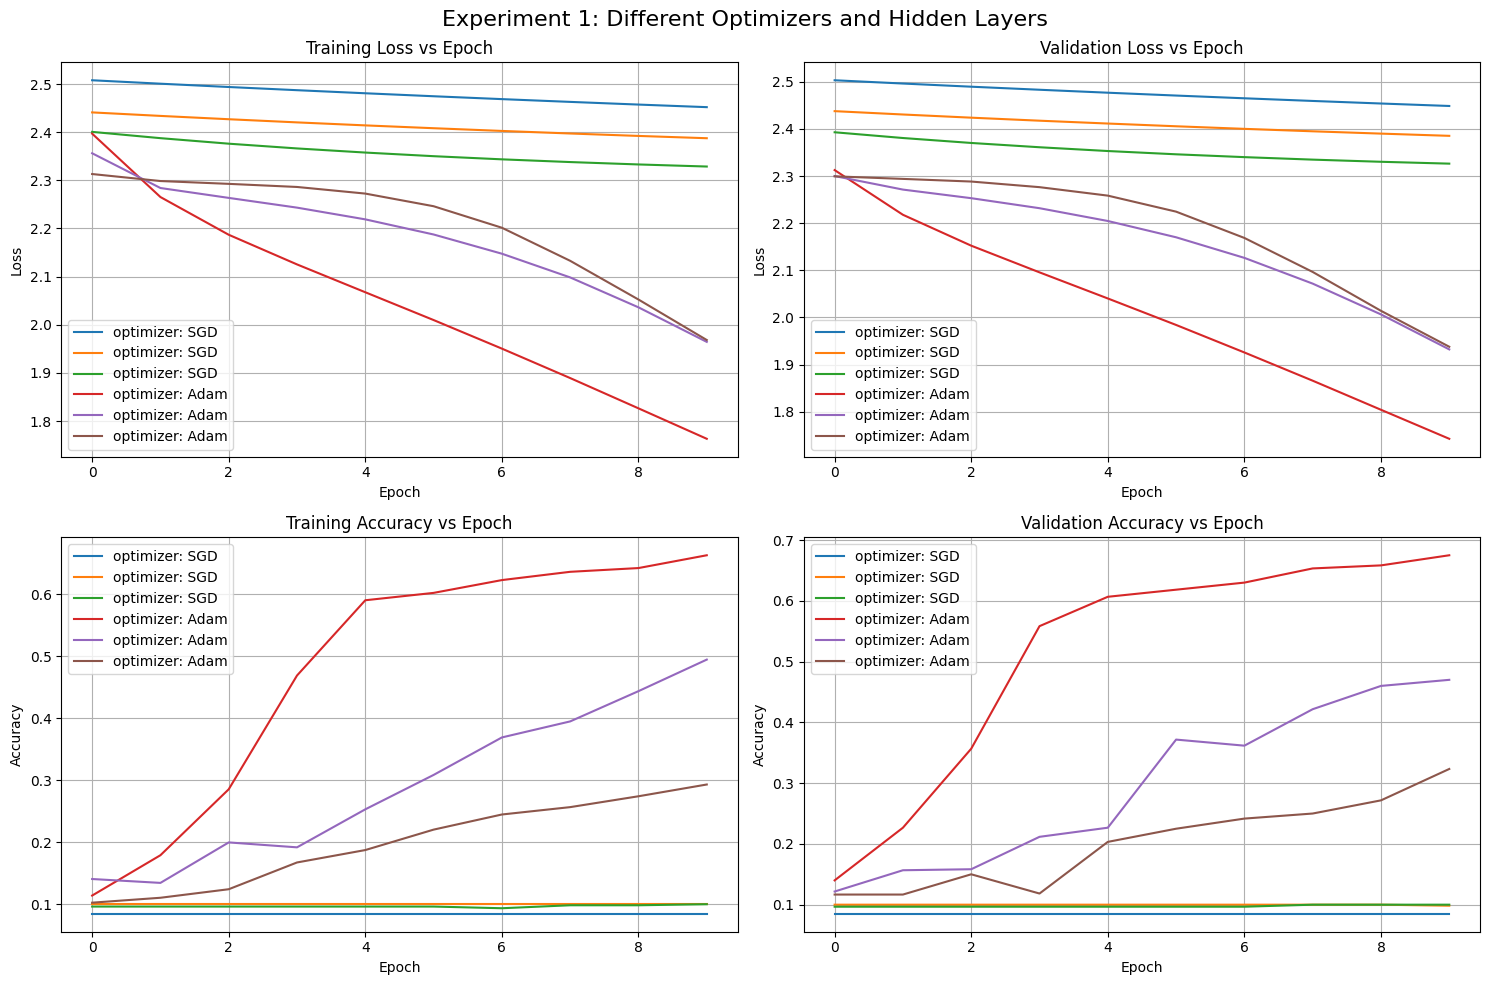

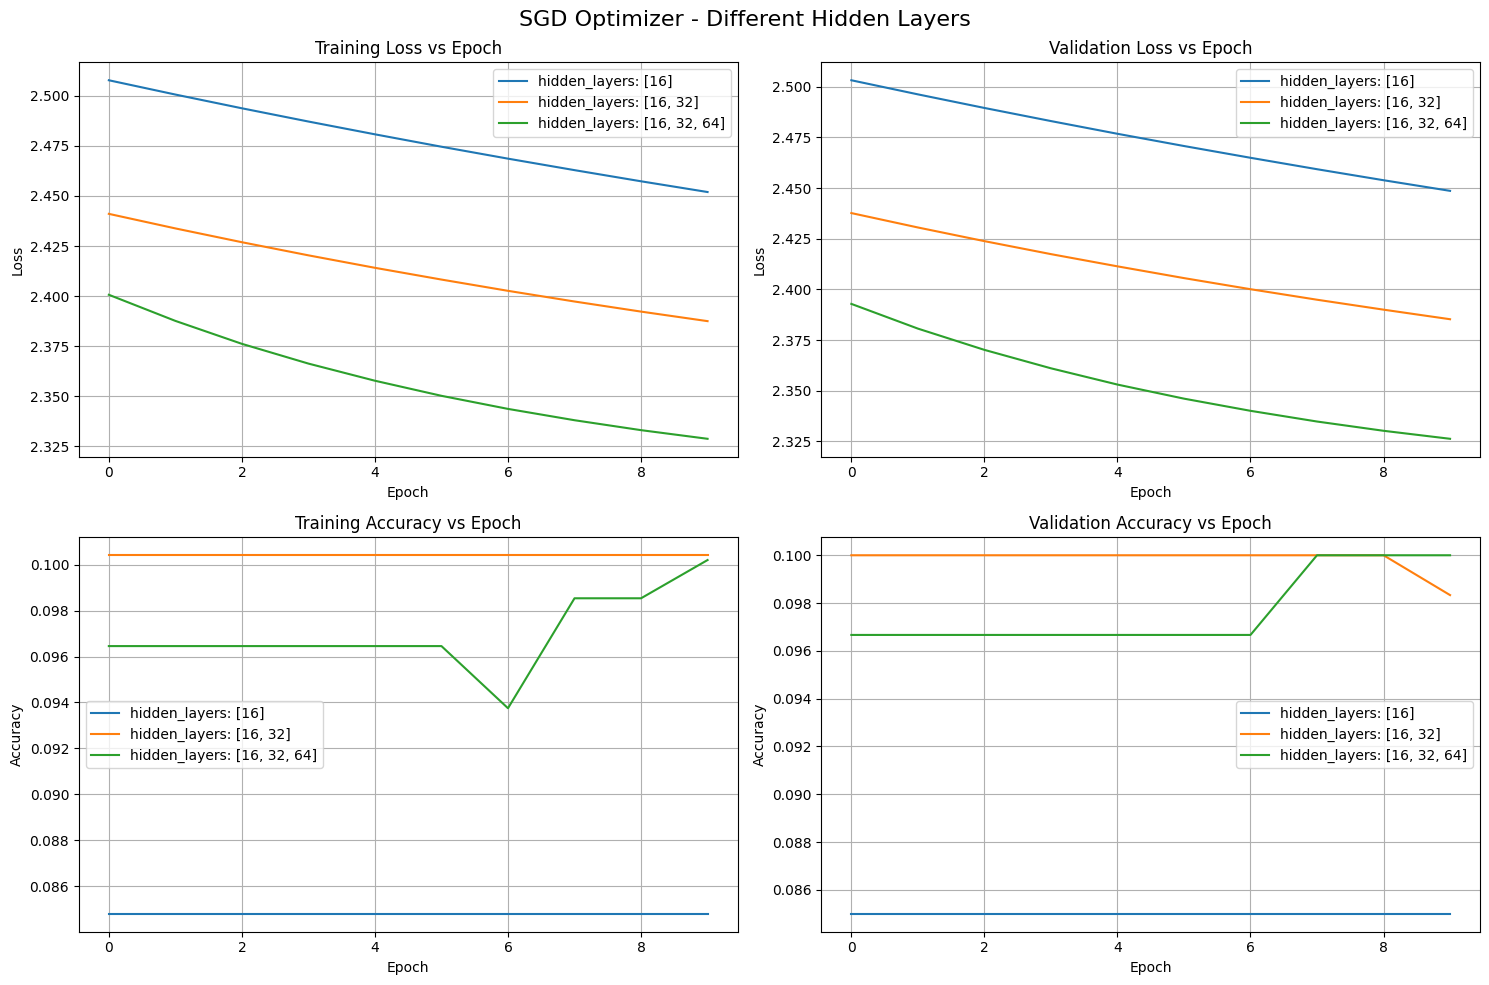

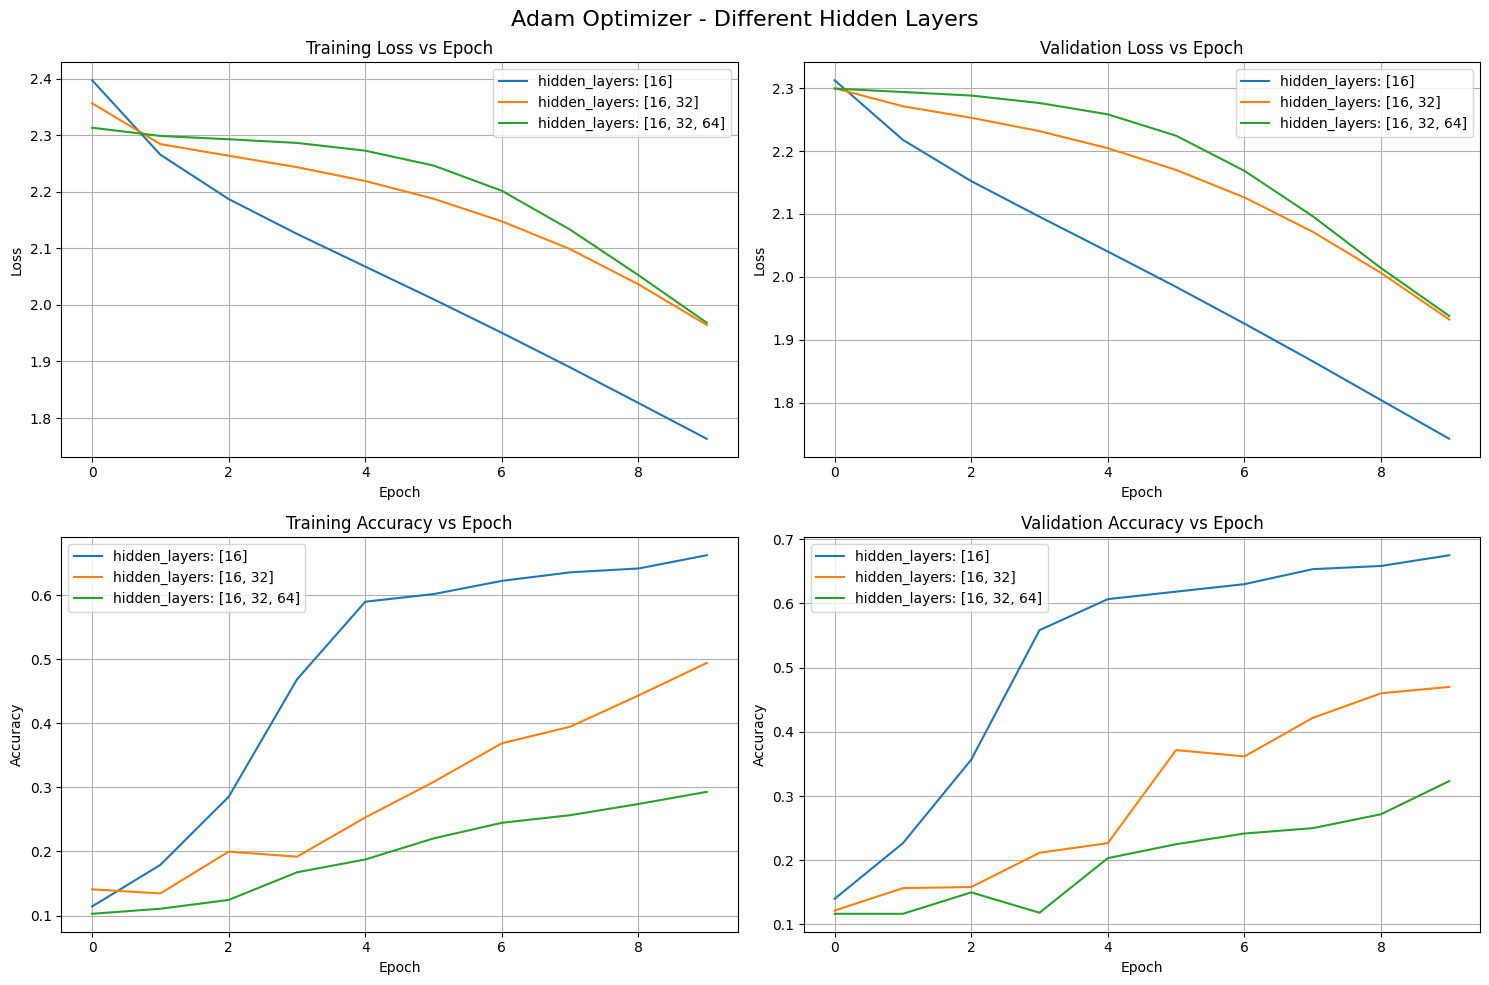

In [16]:
# Visualization functions
def plot_experiment_results(results, title, param_name):
    """
    Plot loss and accuracy curves for experiment results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # Plot training loss
    axes[0, 0].set_title('Training Loss vs Epoch')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    
    # Plot validation loss
    axes[0, 1].set_title('Validation Loss vs Epoch')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    
    # Plot training accuracy
    axes[1, 0].set_title('Training Accuracy vs Epoch')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    
    # Plot validation accuracy
    axes[1, 1].set_title('Validation Accuracy vs Epoch')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    
    for result in results:
        history = result['history']
        label = str(result[param_name])
        
        # Plot losses
        axes[0, 0].plot(history.history['loss'], label=f'{param_name}: {label}')
        axes[0, 1].plot(history.history['val_loss'], label=f'{param_name}: {label}')
        
        # Plot accuracies
        axes[1, 0].plot(history.history['accuracy'], label=f'{param_name}: {label}')
        axes[1, 1].plot(history.history['val_accuracy'], label=f'{param_name}: {label}')
    
    # Add legends
    for ax in axes.flat:
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot results for Experiment 1 (Different Optimizers)
print("Plotting results for Experiment 1...")
plot_experiment_results(results_exp1, 'Experiment 1: Different Optimizers and Hidden Layers', 'optimizer')

# Create separate plots for SGD and Adam
sgd_results = [r for r in results_exp1 if r['optimizer'] == 'SGD']
adam_results = [r for r in results_exp1 if r['optimizer'] == 'Adam']

if sgd_results:
    plot_experiment_results(sgd_results, 'SGD Optimizer - Different Hidden Layers', 'hidden_layers')

if adam_results:
    plot_experiment_results(adam_results, 'Adam Optimizer - Different Hidden Layers', 'hidden_layers')

\nPlotting results for Experiment 2...


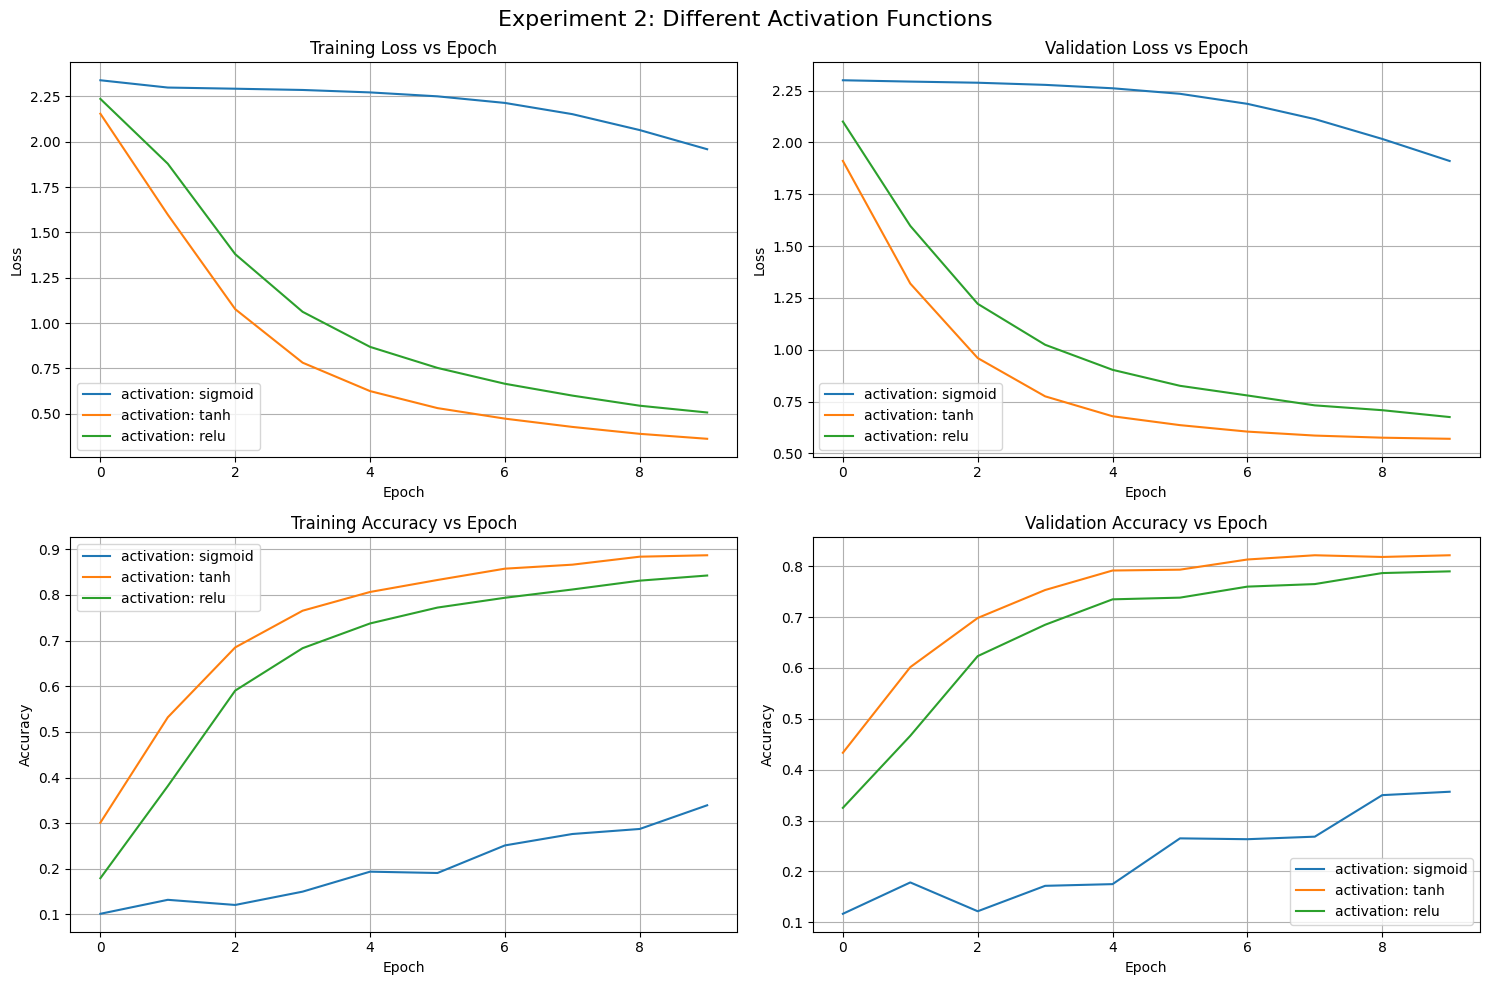

\nPlotting results for Experiment 3...


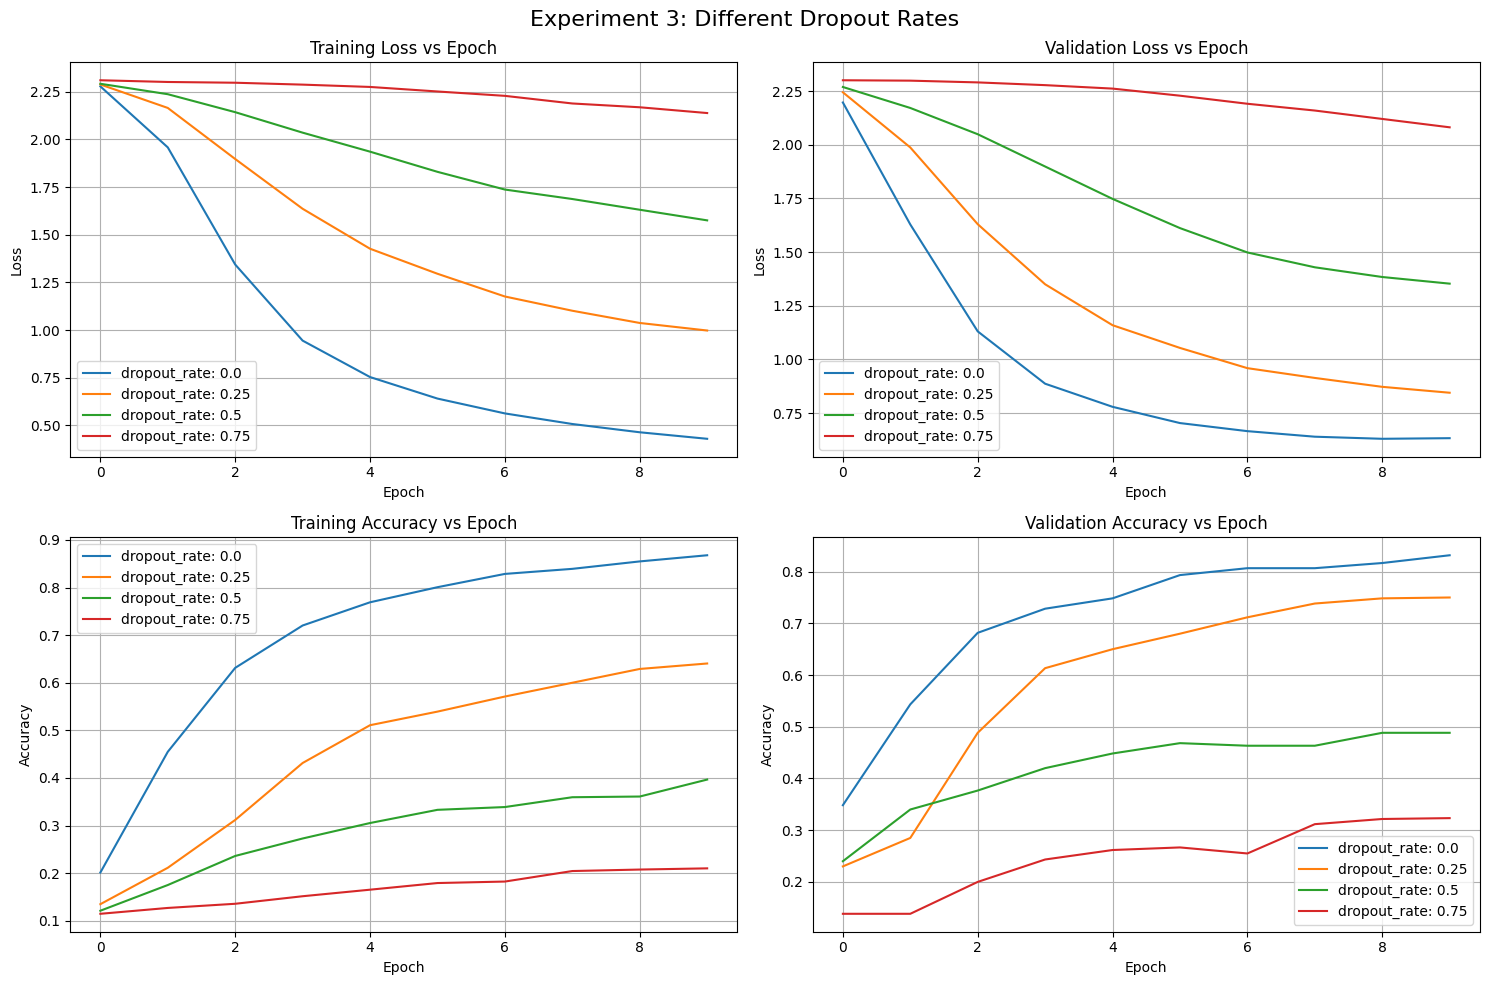

In [17]:
# Plot results for Experiment 2 (Different Activation Functions)
print("\\nPlotting results for Experiment 2...")
plot_experiment_results(results_exp2, 'Experiment 2: Different Activation Functions', 'activation')

# Plot results for Experiment 3 (Different Dropout Rates)
print("\\nPlotting results for Experiment 3...")
plot_experiment_results(results_exp3, 'Experiment 3: Different Dropout Rates', 'dropout_rate')

## Part 5: Learning Rate Optimization

Testing different learning rates with Adam optimizer to find the optimal learning rate:
- 0.01, 0.001, 0.005, 0.0001, 0.0005

Using the best configuration from previous experiments

Finding best configuration from previous experiments...
Best configuration found:
  activation: tanh
  hidden_layers: [16, 32, 64]
  test_accuracy: 0.7933333516120911
  training_time: 11.934440612792969
\nStarting Experiment 4: Different Learning Rates
\nTesting learning rate: 0.01
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5221 - loss: 1.4399 - val_accuracy: 0.7717 - val_loss: 0.8524
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5221 - loss: 1.4399 - val_accuracy: 0.7717 - val_loss: 0.8524
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7985 - loss: 0.6400 - val_accuracy: 0.8183 - val_loss: 0.6269
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7985 - loss: 0.6400 - val_accuracy: 0.8183 - val_loss: 0.6269
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8552 - loss: 0.4549 - val_accuracy: 0.8317 - val_loss: 0.6479
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8552 - loss: 0.45

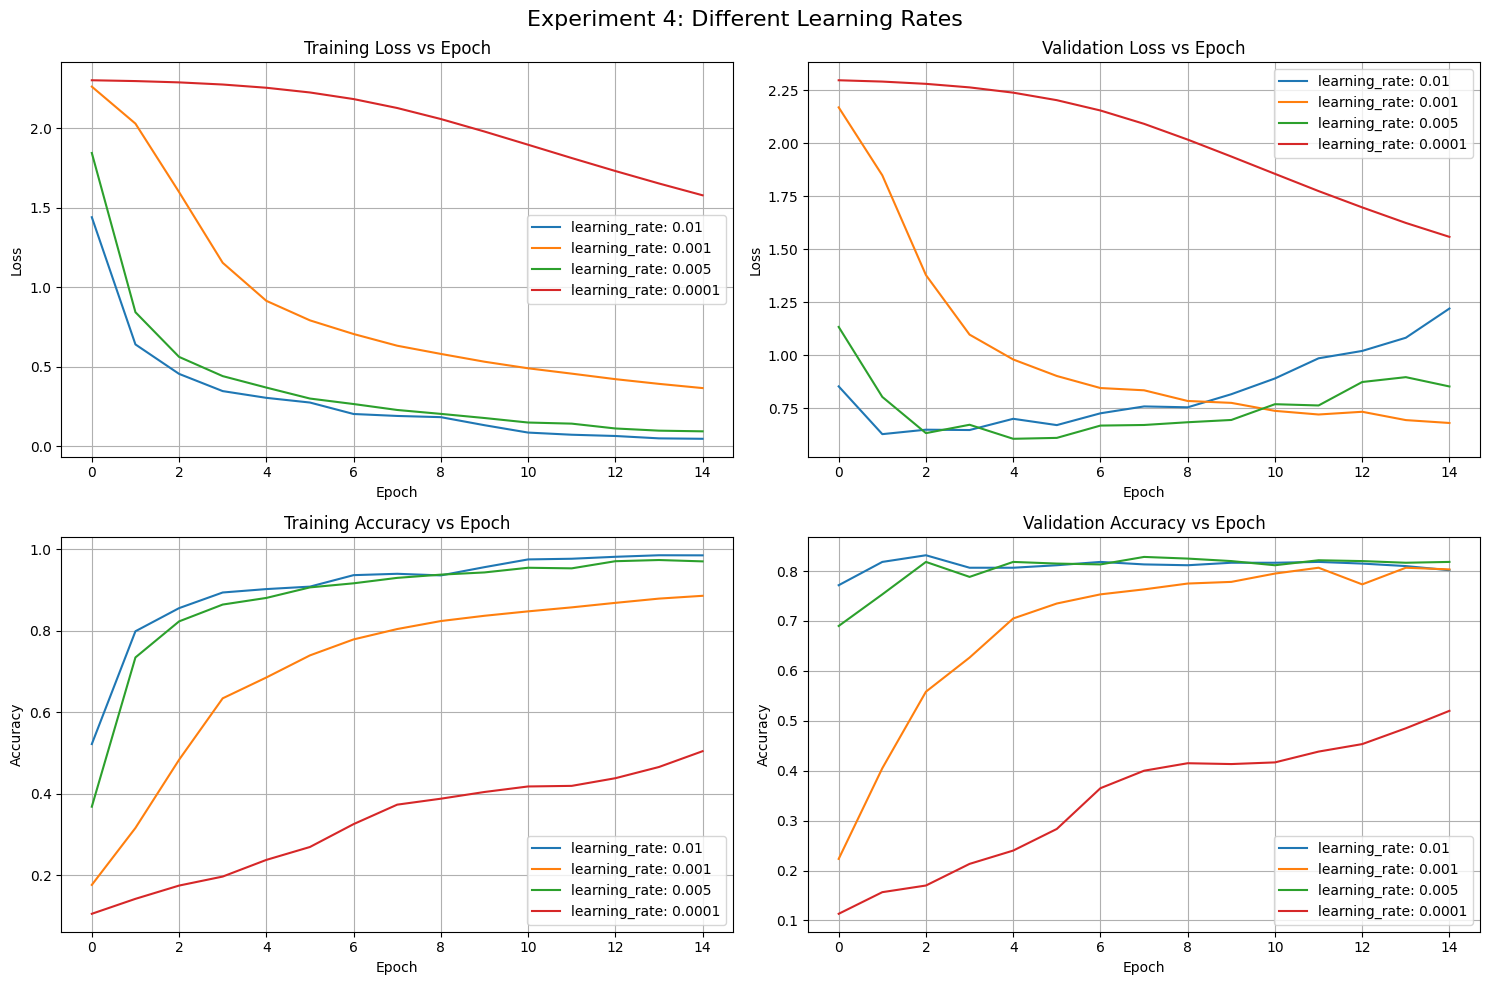

In [18]:
# Find the best configuration from previous experiments
print("Finding best configuration from previous experiments...")

all_results = results_exp1 + results_exp2 + results_exp3
best_result = max(all_results, key=lambda x: x['test_accuracy'])

print(f"Best configuration found:")
for key, value in best_result.items():
    if key != 'history':
        print(f"  {key}: {value}")

# Experiment 4: Different learning rates (simplified for speed)
results_exp4 = []

learning_rates = [0.01, 0.001, 0.005, 0.0001]  # Reduced for speed
hidden_layers = [16, 32, 64]  # Use the best architecture

print("\\nStarting Experiment 4: Different Learning Rates")
print("=" * 50)

# Use ReLU activation (typically performs best) with no dropout for fair comparison
for lr in learning_rates:
    print(f"\\nTesting learning rate: {lr}")
    
    # Create model
    model = create_model(hidden_layers, activation='relu')
    
    # Train and evaluate
    start_time = time.time()
    history, test_acc, train_time = train_evaluate_model(
        model, Adam(learning_rate=lr), 'categorical_crossentropy',
        x_train_flat, y_train_cat,
        x_val_flat, y_val_cat,
        x_test_flat, y_test_cat,
        epochs=15, verbose=1  # Reduced epochs
    )
    
    # Find time to achieve best validation accuracy
    best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
    time_to_best = (best_val_acc_epoch + 1) * (train_time / len(history.history['val_accuracy']))
    
    # Store results
    results_exp4.append({
        'learning_rate': lr,
        'test_accuracy': test_acc,
        'training_time': train_time,
        'time_to_best_val_acc': time_to_best,
        'best_val_accuracy': max(history.history['val_accuracy']),
        'history': history
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")
    print(f"  Time to Best Validation Accuracy: {time_to_best:.2f} seconds")

print("\\nExperiment 4 completed!")

# Plot learning rate results
print("\\nPlotting learning rate results...")
plot_experiment_results(results_exp4, 'Experiment 4: Different Learning Rates', 'learning_rate')

## Part 6: Handwritten Digit Testing

Creating and testing 5 handwritten digit images with the best trained model

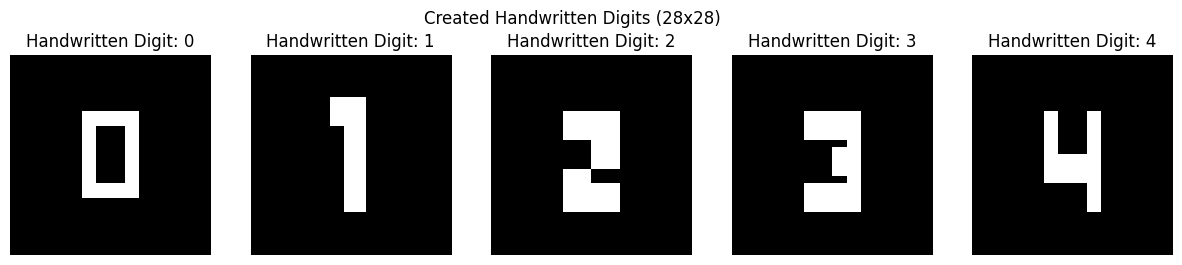

Converting handwritten digits to 32x32 using RBF...
Converting 28x28 images to 32x32 using RBF transformation (optimized)...
Processing image 0/5
\nUsing best model configuration:
Test accuracy: 0.7933
Hidden layers: [16, 32, 64]
Activation: tanh
Dropout rate: 0.0
\nTraining the best model...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2621 - loss: 2.1431 - val_accuracy: 0.4233 - val_loss: 1.8806
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2621 - loss: 2.1431 - val_accuracy: 0.4233 - val_loss: 1.8806
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4869 - loss: 1.5891 - val_accuracy: 0.6483 - val_loss: 1.3087
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4869 - loss: 1.5891 - val_accuracy: 0.6483 - val_loss: 1.3087
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7083 - loss: 1.0849 - val_accuracy: 0.7433 - val_loss: 0.9395
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7083 -

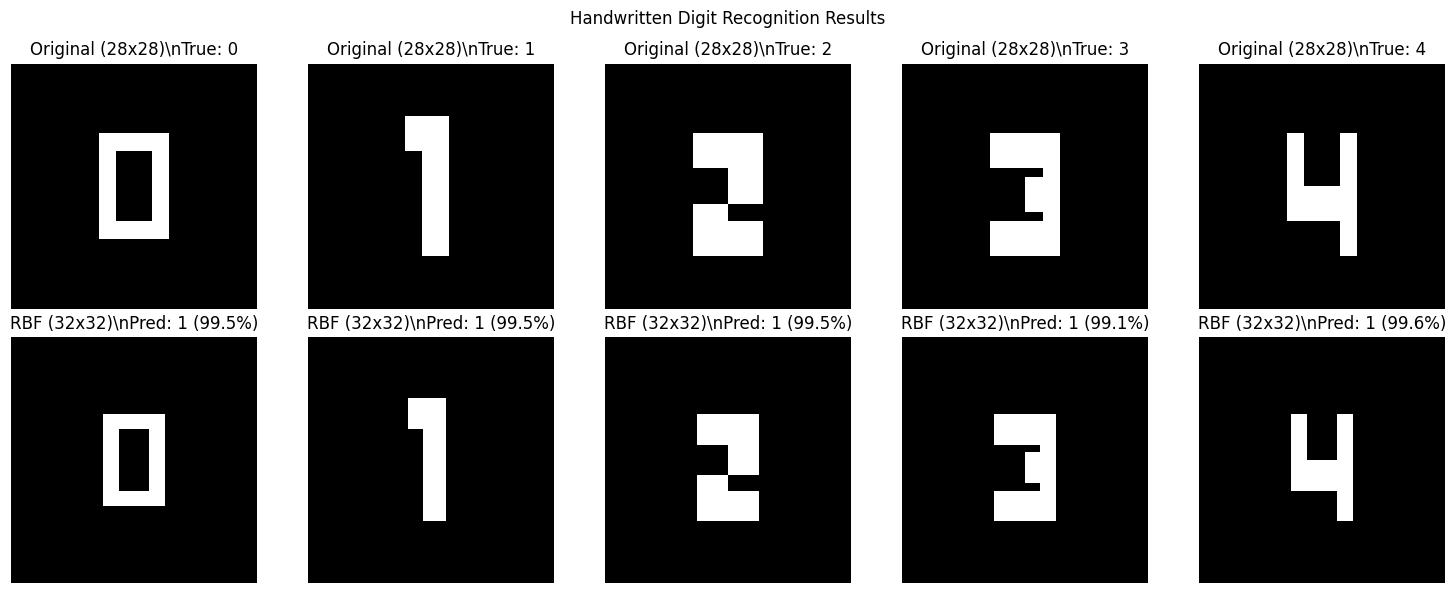

In [19]:
# Create 5 handwritten digit images (simplified synthetic versions)
def create_handwritten_digits():
    """
    Create 5 synthetic handwritten digit images (28x28) for testing
    These are simplified representations of digits 0-4
    """
    digits = np.zeros((5, 28, 28))
    
    # Digit 0
    digits[0, 8:20, 10:18] = 1.0  # Outer rectangle
    digits[0, 10:18, 12:16] = 0.0  # Inner hole
    
    # Digit 1
    digits[1, 6:22, 13:16] = 1.0  # Vertical line
    digits[1, 6:10, 11:13] = 1.0  # Top diagonal
    
    # Digit 2
    digits[2, 8:12, 10:18] = 1.0  # Top horizontal
    digits[2, 12:16, 14:18] = 1.0  # Middle diagonal
    digits[2, 16:20, 10:14] = 1.0  # Bottom diagonal
    digits[2, 18:22, 10:18] = 1.0  # Bottom horizontal
    
    # Digit 3
    digits[3, 8:12, 10:18] = 1.0  # Top horizontal
    digits[3, 13:17, 14:18] = 1.0  # Middle horizontal
    digits[3, 18:22, 10:18] = 1.0  # Bottom horizontal
    digits[3, 8:22, 16:18] = 1.0   # Right vertical
    
    # Digit 4
    digits[4, 8:16, 10:12] = 1.0   # Left vertical
    digits[4, 14:18, 10:18] = 1.0  # Horizontal
    digits[4, 8:22, 16:18] = 1.0   # Right vertical
    
    return digits

# Create handwritten digits
handwritten_digits = create_handwritten_digits()
true_labels = [0, 1, 2, 3, 4]

# Visualize the created digits
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(handwritten_digits[i], cmap='gray')
    axes[i].set_title(f'Handwritten Digit: {true_labels[i]}')
    axes[i].axis('off')
plt.suptitle('Created Handwritten Digits (28x28)')
plt.show()

# Convert to 32x32 using RBF transformation
print("Converting handwritten digits to 32x32 using RBF...")
handwritten_32x32 = convert_28x28_to_32x32_rbf(handwritten_digits)

# Flatten for model input
handwritten_flat = handwritten_32x32.reshape(5, -1)

# Find the best model from all experiments
all_results = results_exp1 + results_exp2 + results_exp3 + results_exp4
best_result = max(all_results, key=lambda x: x['test_accuracy'])

print(f"\\nUsing best model configuration:")
print(f"Test accuracy: {best_result['test_accuracy']:.4f}")

# Recreate the best model
if 'activation' in best_result:
    activation = best_result['activation']
elif 'dropout_rate' in best_result:
    activation = 'relu'
else:
    activation = 'sigmoid'

dropout_rate = best_result.get('dropout_rate', 0.0)
hidden_layers = best_result['hidden_layers']

print(f"Hidden layers: {hidden_layers}")
print(f"Activation: {activation}")
print(f"Dropout rate: {dropout_rate}")

# Create and train the best model
best_model = create_model(hidden_layers, activation=activation, dropout_rate=dropout_rate)
best_model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

print("\\nTraining the best model...")
best_model.fit(x_train_flat, y_train_cat, 
              validation_data=(x_val_flat, y_val_cat),
              epochs=50, batch_size=128, verbose=1)

# Test on handwritten digits
predictions = best_model.predict(handwritten_flat)
predicted_labels = np.argmax(predictions, axis=1)

print("\\nHandwritten Digit Predictions:")
print("=" * 40)
for i in range(5):
    confidence = np.max(predictions[i]) * 100
    print(f"Digit {i}: True={true_labels[i]}, Predicted={predicted_labels[i]}, "
          f"Confidence={confidence:.1f}%")
    
    if predicted_labels[i] == true_labels[i]:
        print("  ✓ Correct prediction!")
    else:
        print("  ✗ Incorrect prediction")

accuracy = np.mean(predicted_labels == true_labels) * 100
print(f"\\nOverall accuracy on handwritten digits: {accuracy:.1f}%")

# Visualize predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original 28x28
    axes[0, i].imshow(handwritten_digits[i], cmap='gray')
    axes[0, i].set_title(f'Original (28x28)\\nTrue: {true_labels[i]}')
    axes[0, i].axis('off')
    
    # Transformed 32x32 with prediction
    axes[1, i].imshow(handwritten_32x32[i], cmap='gray')
    axes[1, i].set_title(f'RBF (32x32)\\nPred: {predicted_labels[i]} ({np.max(predictions[i])*100:.1f}%)')
    axes[1, i].axis('off')

plt.suptitle('Handwritten Digit Recognition Results')
plt.tight_layout()
plt.show()

## Part 7: Results Summary and Analysis

In [20]:
# Comprehensive results summary
print("COMPREHENSIVE RESULTS SUMMARY")
print("=" * 60)

print("\\n1. OPTIMIZER COMPARISON (Experiment 1):")
print("-" * 40)
for result in results_exp1:
    print(f"Optimizer: {result['optimizer']:<4} | "
          f"Loss: {result['loss']:<25} | "
          f"Hidden: {str(result['hidden_layers']):<12} | "
          f"Accuracy: {result['test_accuracy']:.4f}")

print("\\n2. ACTIVATION FUNCTION COMPARISON (Experiment 2):")
print("-" * 50)
for result in results_exp2:
    print(f"Activation: {result['activation']:<7} | "
          f"Hidden: {str(result['hidden_layers']):<12} | "
          f"Accuracy: {result['test_accuracy']:.4f}")

print("\\n3. DROPOUT RATE COMPARISON (Experiment 3):")
print("-" * 45)
for result in results_exp3:
    print(f"Dropout: {result['dropout_rate']:<4} | "
          f"Hidden: {str(result['hidden_layers']):<12} | "
          f"Accuracy: {result['test_accuracy']:.4f}")

print("\\n4. LEARNING RATE COMPARISON (Experiment 4):")
print("-" * 50)
for result in results_exp4:
    print(f"LR: {result['learning_rate']:<6} | "
          f"Accuracy: {result['test_accuracy']:.4f} | "
          f"Time to Best: {result['time_to_best_val_acc']:.2f}s")

# Find best results from each experiment
best_exp1 = max(results_exp1, key=lambda x: x['test_accuracy'])
best_exp2 = max(results_exp2, key=lambda x: x['test_accuracy'])
best_exp3 = max(results_exp3, key=lambda x: x['test_accuracy'])
best_exp4 = max(results_exp4, key=lambda x: x['test_accuracy'])

print("\\n\\nBEST CONFIGURATIONS:")
print("=" * 40)
print(f"Best Optimizer: {best_exp1['optimizer']} with {best_exp1['hidden_layers']} - {best_exp1['test_accuracy']:.4f}")
print(f"Best Activation: {best_exp2['activation']} - {best_exp2['test_accuracy']:.4f}")
print(f"Best Dropout: {best_exp3['dropout_rate']} - {best_exp3['test_accuracy']:.4f}")
print(f"Best Learning Rate: {best_exp4['learning_rate']} - {best_exp4['test_accuracy']:.4f}")

# Overall best
all_results = results_exp1 + results_exp2 + results_exp3 + results_exp4
overall_best = max(all_results, key=lambda x: x['test_accuracy'])
print(f"\\nOVERALL BEST: {overall_best['test_accuracy']:.4f} accuracy")

# Create comparison table
import pandas as pd

# Create summary dataframe
summary_data = []

for result in results_exp1:
    summary_data.append({
        'Experiment': 'Optimizer',
        'Configuration': f"{result['optimizer']} + {result['hidden_layers']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

for result in results_exp2:
    summary_data.append({
        'Experiment': 'Activation',
        'Configuration': f"{result['activation']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

for result in results_exp3:
    summary_data.append({
        'Experiment': 'Dropout',
        'Configuration': f"dropout={result['dropout_rate']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

for result in results_exp4:
    summary_data.append({
        'Experiment': 'Learning Rate',
        'Configuration': f"lr={result['learning_rate']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

summary_df = pd.DataFrame(summary_data)
print("\\nDETAILED RESULTS TABLE:")
print(summary_df.to_string(index=False))

COMPREHENSIVE RESULTS SUMMARY
\n1. OPTIMIZER COMPARISON (Experiment 1):
----------------------------------------
Optimizer: SGD  | Loss: categorical_crossentropy  | Hidden: [16]         | Accuracy: 0.0850
Optimizer: SGD  | Loss: categorical_crossentropy  | Hidden: [16, 32]     | Accuracy: 0.1017
Optimizer: SGD  | Loss: categorical_crossentropy  | Hidden: [16, 32, 64] | Accuracy: 0.1017
Optimizer: Adam | Loss: categorical_crossentropy  | Hidden: [16]         | Accuracy: 0.6467
Optimizer: Adam | Loss: categorical_crossentropy  | Hidden: [16, 32]     | Accuracy: 0.4600
Optimizer: Adam | Loss: categorical_crossentropy  | Hidden: [16, 32, 64] | Accuracy: 0.3067
\n2. ACTIVATION FUNCTION COMPARISON (Experiment 2):
--------------------------------------------------
Activation: sigmoid | Hidden: [16, 32, 64] | Accuracy: 0.3567
Activation: tanh    | Hidden: [16, 32, 64] | Accuracy: 0.7933
Activation: relu    | Hidden: [16, 32, 64] | Accuracy: 0.7617
\n3. DROPOUT RATE COMPARISON (Experiment 3):
-